# University of Mannheim
## Data Mining I -- Group Project
### Wine Quality Prediction
#### Team members:
* Anna-Lena Blinken
* Max Darmstadt
* Nicolas Hautschek
* Erik Penther
* Nicolas Fürhaupter

## Importing Libraries and Data

In [1]:
#from google.colab import drive
#drive.mount('/gdrive')
#%cd /gdrive

In [2]:
# Import libraries

# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

# Libraries for the preprocessing
from sklearn.model_selection import train_test_split

# Liraries for the model creation
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Libraries for the evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import itertools

# Libraries for the model adaption
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE 
from collections import Counter
from sklearn.inspection import permutation_importance
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from math import sqrt

In [3]:
# Import wine data

wine_data = pd.read_csv('../winequalityN.csv')
wine_data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


## Visualize and Analyse Data

In [4]:
# Print wine data info

wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [5]:
# Analyse the data by its mean etc.

wine_data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


### Null Values

In [6]:
# Check data for null values

wine_data.isnull().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [7]:
# Check class distribution

wine_data.quality.value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

### Class Distribution

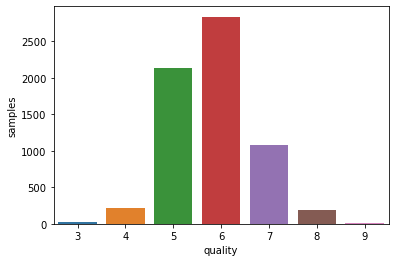

In [8]:
# Visualize class distribution

sns.barplot(x=wine_data.quality.value_counts().index, y=wine_data.quality.value_counts())
plt.ylabel('samples')
plt.xlabel('quality')
plt.show()

In [9]:
# Turn 10 classes into 3 classes

wine_data['quality'] = wine_data.quality.apply(lambda x: 2 if x>6 else (1 if x> 4 else 0))

In [10]:
# Check class distribution

wine_data.quality.value_counts()

1    4974
2    1277
0     246
Name: quality, dtype: int64

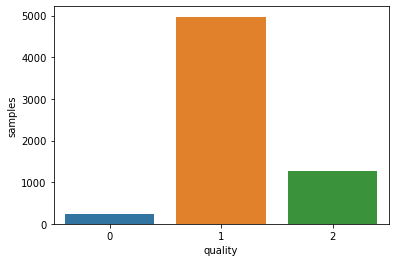

In [11]:
# Visualize class distribution

sns.barplot(x=wine_data.quality.value_counts().index, y=wine_data.quality.value_counts())
plt.ylabel('samples')
plt.xlabel('quality')
plt.show()

In [12]:
# Turn 10 classes into 2 classes

wine_data_2 = pd.read_csv('../winequalityN.csv')
wine_data_2['quality'] = wine_data_2.quality.apply(lambda x: 2 if x>5 else 0)

In [13]:
# Check class distribution

wine_data_2.quality.value_counts()

2    4113
0    2384
Name: quality, dtype: int64

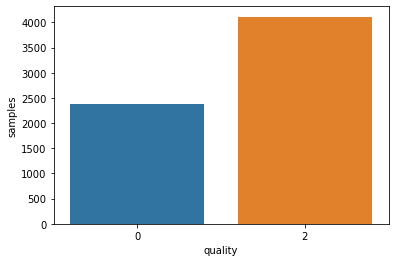

In [14]:
# Visualize class distribution

sns.barplot(x=wine_data_2.quality.value_counts().index, y=wine_data_2.quality.value_counts())
plt.ylabel('samples')
plt.xlabel('quality')
plt.show()

### Check duplicates

In [15]:
# Count duplicates and remove duplicates

display(len(wine_data.index))
wine_data.drop_duplicates()
display(len(wine_data.index))

6497

6497

### Unique Values

In [16]:
# Count uniques values of each column

wine_data.nunique()

type                      2
fixed acidity           106
volatile acidity        187
citric acid              89
residual sugar          316
chlorides               214
free sulfur dioxide     135
total sulfur dioxide    276
density                 998
pH                      108
sulphates               111
alcohol                 111
quality                   3
dtype: int64

### Distribution of Values

<AxesSubplot:>

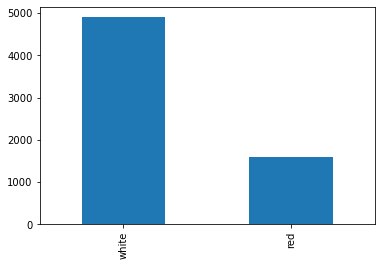

In [17]:
# Plot histogram for each categorical column

wine_data['type'].value_counts().plot(kind='bar')

array([[<AxesSubplot:title={'center':'fixed acidity'}>,
        <AxesSubplot:title={'center':'volatile acidity'}>,
        <AxesSubplot:title={'center':'citric acid'}>],
       [<AxesSubplot:title={'center':'residual sugar'}>,
        <AxesSubplot:title={'center':'chlorides'}>,
        <AxesSubplot:title={'center':'free sulfur dioxide'}>],
       [<AxesSubplot:title={'center':'total sulfur dioxide'}>,
        <AxesSubplot:title={'center':'density'}>,
        <AxesSubplot:title={'center':'pH'}>],
       [<AxesSubplot:title={'center':'sulphates'}>,
        <AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'quality'}>]], dtype=object)

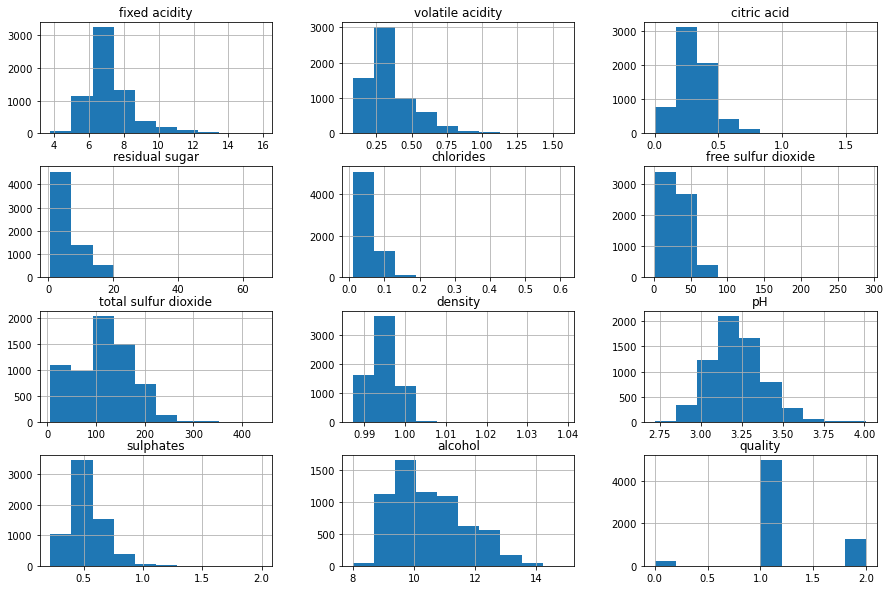

In [18]:
# Plot histogram for each numerical column

wine_data.hist(figsize=(15, 10))

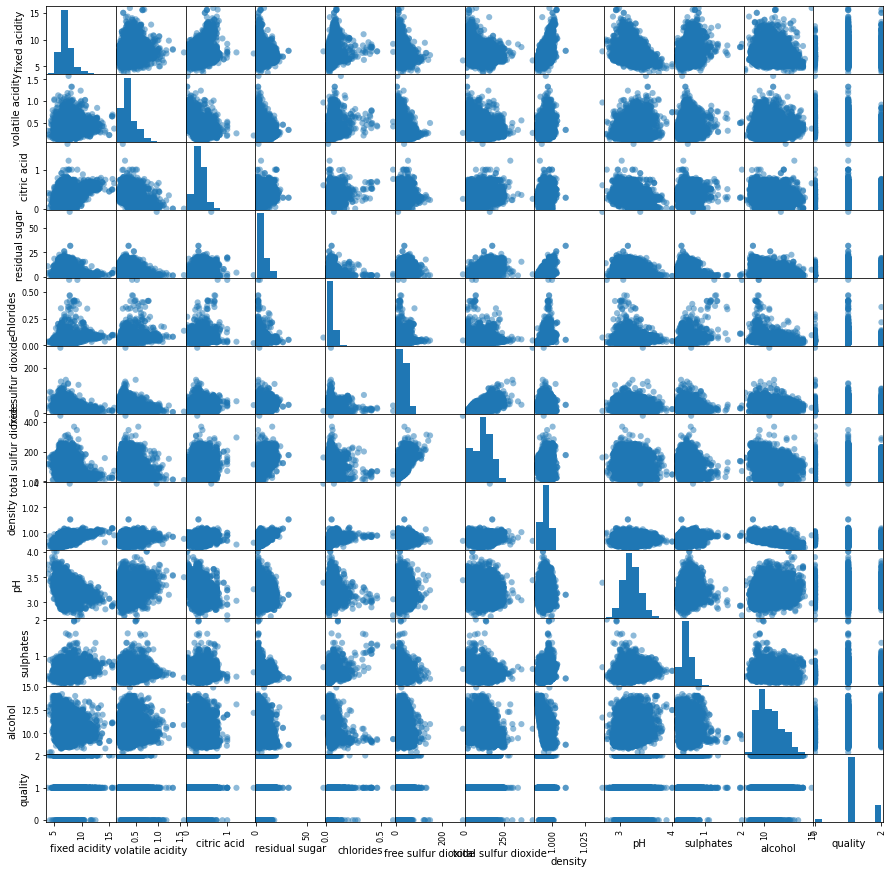

In [19]:
# Plot scatterplots for all possible combinations of columns

pd.plotting.scatter_matrix(wine_data, figsize=(15, 15), s=150);

## Data Cleaning

In [20]:
# Delete null-values 

wine_data = wine_data.dropna(axis=0, how="any", thresh=None, subset=None, inplace=False)
display(wine_data.isnull().sum())
display(len(wine_data.index))

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

6463

In [21]:
# Ordinal Encoder for the attribute type

# Show data before preprocessing
display(wine_data.head())

# Create the OrdinalEncoder
ordinal_encoder = preprocessing.OrdinalEncoder()

# Preprocess the categorical feature type
wine_data[['type']] = ordinal_encoder.fit_transform(wine_data[['type']])

# Show the results
wine_data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1.0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,1.0,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,1.0,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,1.0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,1.0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


In [22]:
# Normalisation of the numerical values

# Show data before preprocessing
display(wine_data.head())

# Create the normaliser
scaler = preprocessing.MinMaxScaler()

# Preprocess the all numerical features
wine_data[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']] = scaler.fit_transform(wine_data[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']])

# Show the results
display(wine_data.head())

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1.0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,1.0,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,1.0,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,1.0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,1.0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1.0,0.264463,0.126667,0.216867,0.308282,0.059801,0.152778,0.377880,0.267785,0.217054,0.129213,0.115942,1
1,1.0,0.206612,0.146667,0.204819,0.015337,0.066445,0.045139,0.290323,0.132832,0.449612,0.151685,0.217391,1
2,1.0,0.355372,0.133333,0.240964,0.096626,0.068106,0.100694,0.209677,0.154039,0.418605,0.123596,0.304348,1
3,1.0,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.101124,0.275362,1
4,1.0,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.101124,0.275362,1


In [23]:
# Deleting outliers

# Defining columns for the outlier detection (type and quality are not included)
wine_data_columns = ['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

# Identify outliers
for x in wine_data_columns:
    for y in x:
        q75,q25 = np.percentile(wine_data.loc[:,x],[95,5])
        intr_qr = q75-q25

        max = q75+(1.5*intr_qr)
        min = q25-(1.5*intr_qr)

        wine_data.loc[wine_data[x] < min,x] = np.nan
        wine_data.loc[wine_data[x] > max,x] = np.nan
display(wine_data.isnull().sum())

# Drop outliers
wine_data = wine_data.dropna(axis=0, how="any", thresh=None, subset=None, inplace=False)
display(wine_data.isnull().sum())
display(len(wine_data.index))

type                     0
fixed acidity            0
volatile acidity         1
citric acid              1
residual sugar           1
chlorides               47
free sulfur dioxide      2
total sulfur dioxide     0
density                  1
pH                       0
sulphates                8
alcohol                  0
quality                  0
dtype: int64

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

6406

### Seperation of features and the target variable and test train split

In [24]:
# Seperation of features and the target variable in two different data frames

wine_data = wine_data.copy()

features = wine_data.drop(columns='quality')
display(features.head())

target = wine_data.drop(columns=['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'])
target = target['quality'].ravel()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,1.0,0.264463,0.126667,0.216867,0.308282,0.059801,0.152778,0.377880,0.267785,0.217054,0.129213,0.115942
1,1.0,0.206612,0.146667,0.204819,0.015337,0.066445,0.045139,0.290323,0.132832,0.449612,0.151685,0.217391
2,1.0,0.355372,0.133333,0.240964,0.096626,0.068106,0.100694,0.209677,0.154039,0.418605,0.123596,0.304348
3,1.0,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.101124,0.275362
4,1.0,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.101124,0.275362


In [25]:
# Train test split

data_train, data_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target)

## Random Forest

In [26]:
# Model Creation

# Create estimator and pipeline
random_forest = RandomForestClassifier(max_depth=2, random_state=0)
pipeline_rf = Pipeline([('estimator', random_forest)])

# Fit the model and predict the values for the train data
pipeline_rf.fit(data_train, target_train)
predictions_train_rf = pipeline_rf.predict(data_train)

### Evaluation

In [27]:
# Predict values for the test data

predictions_test_rf = pipeline_rf.predict(data_test)

#### Makro F1-Score, Makro Precision, and Makro Recall

In [28]:
# Makro F1-Score
print("Makro F1-Score Train Data:")
f1_score_train_rf = f1_score(target_train, predictions_train_rf, average='macro')
display(f1_score_train_rf)

print("Makro F1-Score Test Data:")
f1_score_test_rf = f1_score(target_test, predictions_test_rf, average='macro')
display(f1_score_test_rf)

# Makro Precision Score
print("Makro Precision Train Data:")
precision_train_rf = precision_score(target_train, predictions_train_rf, average='macro', zero_division = 0)
display(precision_train_rf)

print("Makro Precision Test Data:")
precision_test_rf = precision_score(target_test, predictions_test_rf, average='macro', zero_division = 0)
display(precision_test_rf)

# Makro Recall Score
print("Makro Recall Train Data:")
recall_train_rf = recall_score(target_train, predictions_train_rf, average='macro')
display(recall_train_rf)

print("Makro Recall Test Data:")
recall_test_rf = recall_score(target_test, predictions_test_rf, average='macro')
display(recall_test_rf)

Makro F1-Score Train Data:


0.28891592023296103

Makro F1-Score Test Data:


0.2889969067609368

Makro Precision Train Data:


0.254944054124382

Makro Precision Test Data:


0.2550702028081123

Makro Recall Train Data:


0.3333333333333333

Makro Recall Test Data:


0.3333333333333333

#### Confusion Matrix

In [29]:
# Function to plot a confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion Matrix Train Data:


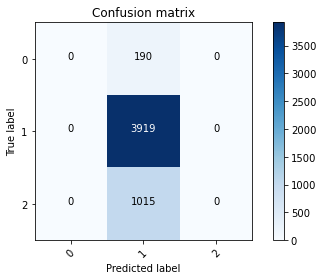

In [30]:
# Confusion Matrix for the training data

cnf_matrix_train_rf = confusion_matrix(target_train, predictions_train_rf)
np.set_printoptions(precision=2)
print("Confusion Matrix Train Data:")
plot_confusion_matrix(cnf_matrix_train_rf, classes=np.array([0,1,2]))

Confusion Matrix Test Data:


None

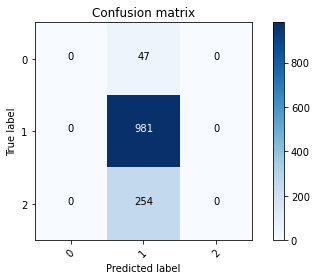

In [31]:
# Confusion Matrix for the test data

cnf_matrix_test_rf = confusion_matrix(target_test, predictions_test_rf)
np.set_printoptions(precision=2)
print("Confusion Matrix Test Data:")
display(plot_confusion_matrix(cnf_matrix_test_rf, classes=np.array([0,1,2])))

## Adoption of the Mode 
1. First Hyperparameter Tuning
2. Oversampling
3. Feature Selection
4. Second Hyperparameter Tuning

In each step the best model, which was achieved until that stage, is utilized.

### First Hyperparameter Tuning

In [32]:
# Create an estimator
random_forest = RandomForestClassifier()

# Specify the parameter grid
parameters = {
    #'max_depth': range(5, 14),
    #'n_estimators': [100, 300, 500, 700],
    #'max_features': [None, sqrt, 0.3, 2],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    
}

# Specify the cross validation
stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Create the grid search instance
grid_search_estimator = GridSearchCV(random_forest, parameters, scoring='f1_macro', cv=stratified_10_fold_cv, n_jobs = -1, verbose = 2, return_train_score=False)

# Run the grid search
grid_search_estimator.fit(data_train, target_train)

# Print the results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)
display(results)
    
# Print the best parameter setting
print("best score is {} with params {}".format(grid_search_estimator.best_score_, grid_search_estimator.best_params_))

Fitting 10 folds for each of 9 candidates, totalling 90 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,1.081444,0.029371,0.048779,0.037269,3,8,"{'min_samples_leaf': 3, 'min_samples_split': 8}",0.502238,0.473270,0.500567,0.512192,0.474542,0.525544,0.527017,0.487442,0.479193,0.518775,0.500078,0.019601,1
1,1.096113,0.025561,0.033619,0.006486,3,10,"{'min_samples_leaf': 3, 'min_samples_split': 10}",0.495721,0.472903,0.517950,0.478767,0.479193,0.522406,0.502102,0.487340,0.485725,0.518775,0.496088,0.017403,2
2,1.075140,0.016803,0.029860,0.002641,3,12,"{'min_samples_leaf': 3, 'min_samples_split': 12}",0.492400,0.488208,0.499101,0.472903,0.479723,0.487518,0.506937,0.482359,0.477092,0.505177,0.489142,0.011094,6
3,1.090201,0.023957,0.036353,0.009348,4,8,"{'min_samples_leaf': 4, 'min_samples_split': 8}",0.495715,0.477634,0.510064,0.468291,0.484363,0.483159,0.504509,0.498916,0.486635,0.517483,0.492677,0.014570,3
4,1.042677,0.015209,0.032838,0.005280,4,10,"{'min_samples_leaf': 4, 'min_samples_split': 10}",0.505447,0.486444,0.500752,0.471353,0.476313,0.479399,0.509422,0.490611,0.473185,0.523451,0.491638,0.016634,4
5,1.005231,0.013238,0.030687,0.005133,4,12,"{'min_samples_leaf': 4, 'min_samples_split': 12}",0.489137,0.465822,0.488934,0.468129,0.473016,0.482684,0.498305,0.488968,0.448827,0.513088,0.481691,0.017363,9
6,1.033138,0.010910,0.030170,0.001927,5,8,"{'min_samples_leaf': 5, 'min_samples_split': 8}",0.484044,0.486595,0.494018,0.460712,0.465902,0.485934,0.507194,0.485579,0.458343,0.509988,0.483831,0.016895,8
7,1.068841,0.027152,0.033861,0.004040,5,10,"{'min_samples_leaf': 5, 'min_samples_split': 10}",0.495715,0.483016,0.490691,0.477463,0.476079,0.480961,0.511245,0.495636,0.483962,0.497254,0.489202,0.010394,5
8,0.893528,0.157725,0.023739,0.004786,5,12,"{'min_samples_leaf': 5, 'min_samples_split': 12}",0.494018,0.463743,0.497379,0.480629,0.477850,0.476079,0.508293,0.485579,0.477092,0.484124,0.484479,0.011999,7


best score is 0.5000778430439152 with params {'min_samples_leaf': 3, 'min_samples_split': 8}


#### Model with Hyperparameter Tuning
As a basis the model without the feature type is used, as this model creates the best outcome for both train and test data and reduces the difference between train and test data.

Makro F1-Score Train Data:


0.629831210898244

Makro F1-Score Test Data:


0.4925005447174681

Makro Precision Train Data:


0.9538051750380517

Makro Precision Test Data:


0.5314773433693443

Makro Recall Train Data:


0.5890343451081796

Makro Recall Test Data:


0.4779016537305925

Confusion Matrix Train Data:


None

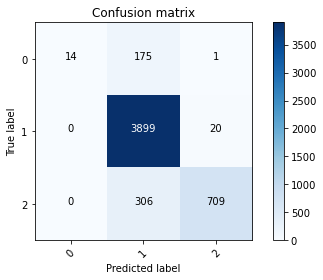

In [33]:
# Changing Hyperparameters

# Creation of the RandomForest and the pipeline
random_forest = RandomForestClassifier(random_state=0, max_depth = 11, n_estimators = 500, max_features=0.3, min_samples_leaf=3,
    min_samples_split=8)
pipeline_rf = Pipeline([('estimator', random_forest)])

# Fit the model and predict the values for the train data
pipeline_rf.fit(data_train, target_train)
predictions_train_rf = pipeline_rf.predict(data_train)

# Predict values for the test data
predictions_test_rf = pipeline_rf.predict(data_test)

# Makro F1-Score
print("Makro F1-Score Train Data:")
f1_score_train_rf = f1_score(target_train, predictions_train_rf, average='macro')
display(f1_score_train_rf)

print("Makro F1-Score Test Data:")
f1_score_test_rf = f1_score(target_test, predictions_test_rf, average='macro')
display(f1_score_test_rf)

# Makro Precision Score
print("Makro Precision Train Data:")
precision_train_rf = precision_score(target_train, predictions_train_rf, average='macro', zero_division = 0)
display(precision_train_rf)

print("Makro Precision Test Data:")
precision_test_rf = precision_score(target_test, predictions_test_rf, average='macro', zero_division = 0)
display(precision_test_rf)

# Makro Recall Score
print("Makro Recall Train Data:")
recall_train_rf = recall_score(target_train, predictions_train_rf, average='macro')
display(recall_train_rf)

print("Makro Recall Test Data:")
recall_test_rf = recall_score(target_test, predictions_test_rf, average='macro')
display(recall_test_rf)

# Confusion Matrix for the training data
cnf_matrix_train_rf = confusion_matrix(target_train, predictions_train_rf)
np.set_printoptions(precision=2)
print("Confusion Matrix Train Data:")
display(plot_confusion_matrix(cnf_matrix_train_rf, classes=np.array([0,1,2])))

Confusion Matrix Train Data:


None

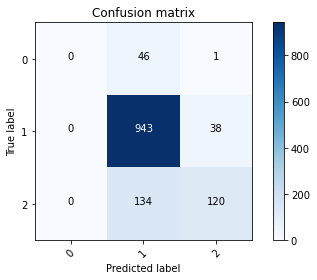

In [34]:
# Confusion Matrix for the training data

cnf_matrix_test_rf = confusion_matrix(target_test, predictions_test_rf)
np.set_printoptions(precision=2)
print("Confusion Matrix Train Data:")
display(plot_confusion_matrix(cnf_matrix_test_rf, classes=np.array([0,1,2])))

### Oversampling
On the basis of the model with the hypertuning of the parameters.

Makro F1-Score Train Data:


0.9344379842148247

Makro F1-Score Test Data:


0.6096806232236647

Makro Precision Train Data:


0.9360941483269579

Makro Precision Test Data:


0.5745525793279441

Makro Recall Train Data:


0.9351875478438377

Makro Recall Test Data:


0.7078814217778376

Confusion Matrix Train Data:


None

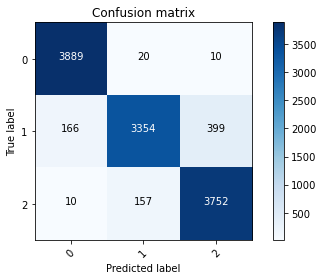

In [35]:
# Oversampling
data_train_smt = data_train.copy() 
target_train_smt = target_train.copy() 

smt = SMOTE(random_state=42)
data_train, target_train = smt.fit_resample(data_train_smt, target_train_smt)

# Create estimator and pipeline
random_forest = RandomForestClassifier(random_state=0, max_depth = 11, n_estimators = 500, max_features=0.3, min_samples_leaf=3,
    min_samples_split=8)
pipeline_rf = Pipeline([('estimator', random_forest)])

# Fit the model and predict the values for the train data
pipeline_rf.fit(data_train, target_train)
predictions_train_rf = pipeline_rf.predict(data_train)

# Predict values for the test data
predictions_test_rf = pipeline_rf.predict(data_test)

# Makro F1-Score
print("Makro F1-Score Train Data:")
f1_score_train_rf = f1_score(target_train, predictions_train_rf, average='macro')
display(f1_score_train_rf)

print("Makro F1-Score Test Data:")
f1_score_test_rf = f1_score(target_test, predictions_test_rf, average='macro')
display(f1_score_test_rf)

# Makro Precision Score
print("Makro Precision Train Data:")
precision_train_rf = precision_score(target_train, predictions_train_rf, average='macro', zero_division = 0)
display(precision_train_rf)

print("Makro Precision Test Data:")
precision_test_rf = precision_score(target_test, predictions_test_rf, average='macro', zero_division = 0)
display(precision_test_rf)

# Makro Recall Score
print("Makro Recall Train Data:")
recall_train_rf = recall_score(target_train, predictions_train_rf, average='macro')
display(recall_train_rf)

print("Makro Recall Test Data:")
recall_test_rf = recall_score(target_test, predictions_test_rf, average='macro')
display(recall_test_rf)

# Confusion Matrix for the training data
cnf_matrix_train_rf = confusion_matrix(target_train, predictions_train_rf)
np.set_printoptions(precision=2)
print("Confusion Matrix Train Data:")
display(plot_confusion_matrix(cnf_matrix_train_rf, classes=np.array([0,1,2])))

Confusion Matrix Test Data:


None

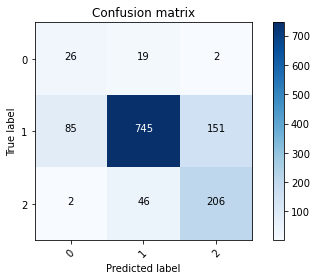

In [36]:
# Confusion Matrix for the test data

cnf_matrix_test_rf = confusion_matrix(target_test, predictions_test_rf)
np.set_printoptions(precision=2)
print("Confusion Matrix Test Data:")
display(plot_confusion_matrix(cnf_matrix_test_rf, classes=np.array([0,1,2])))

### Feature Selection
On the basis of the model with the hypertuning of the parameters and the oversampling.

[0.01 0.06 0.11 0.08 0.07 0.07 0.13 0.08 0.09 0.05 0.08 0.16]


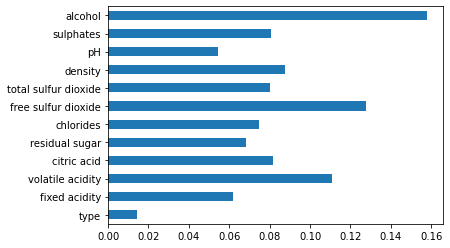

In [37]:
# Feature Importance

print(random_forest.feature_importances_) 
feat_importances = pd.Series(random_forest.feature_importances_, index=features.columns)
feat_importances.plot(kind='barh')
plt.show()

Text(0.5, 0, 'Permutation Importance')

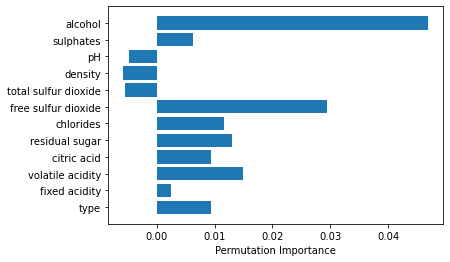

In [38]:
# Permutation Importance

perm_importance = permutation_importance(random_forest, data_test, target_test)
feature_list = list(features)
plt.barh(feature_list, perm_importance.importances_mean)
plt.xlabel("Permutation Importance")

In [39]:
# Feature correlation

wines = wine_data.copy()
y_ql = wines.drop(columns=['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'])

def VRF(predict, data, y):
   
    scale = StandardScaler(with_std=False)
    df = pd.DataFrame(scale.fit_transform(data), columns= cols)
    features = "+".join(cols)
    df['quality_label'] = y.values

    # Get y and X dataframes based on this regression:
    y, X = dmatrices(predict + ' ~' + features, data = df, return_type='dataframe')

    # Calculate VIF Factors: For each X, calculate VIF and save it in the dataframe
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns

    # Inspect VIF Factors
    display(vif.sort_values('VIF Factor'))
    return vif

cols = wines.columns.str.replace(' ', '_')
df = wines.copy()
df.columns = cols

vif = VRF('quality', df.loc[:, cols], y_ql)

,VIF Factor,features
0,1.000000,Intercept
13,1.243562,quality
11,1.559567,sulphates
4,1.617980,citric_acid
6,1.969709,chlorides
3,2.219198,volatile_acidity
7,2.253225,free_sulfur_dioxide
10,2.740514,pH
8,4.037936,total_sulfur_dioxide
2,5.750609,fixed_acidity


####  Feature Importance: Model without type

Makro F1-Score Train Data:


0.9380449313121125

Makro F1-Score Test Data:


0.6094263998365771

Makro Precision Train Data:


0.9393587555109436

Makro Precision Test Data:


0.5742439622721313

Makro Recall Train Data:


0.9386748320149697

Makro Recall Test Data:


0.704963781895667

Confusion Matrix Train Data:


None

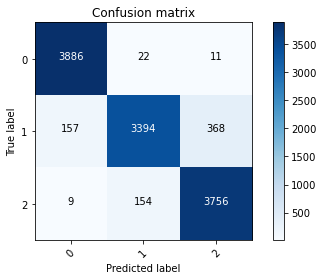

In [41]:
# Seperation of features and the target variable in two different data frames and dropping column type
features = wine_data.drop(columns=['quality', 'type'])
target = wine_data.drop(columns=['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'])
target = target['quality'].ravel()

# Train test split
data_train, data_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target)

# Oversampling
data_train_smt = data_train.copy() 
target_train_smt = target_train.copy() 

smt = SMOTE(random_state=42)
data_train, target_train = smt.fit_resample(data_train_smt, target_train_smt)

# Create estimator and pipeline
random_forest = RandomForestClassifier(random_state=0, max_depth = 11, n_estimators = 500, max_features=0.3, min_samples_leaf=3,
    min_samples_split=8)
pipeline_rf = Pipeline([('estimator', random_forest)])

# Fit the model and predict the values for the train data
pipeline_rf.fit(data_train, target_train)
predictions_train_rf = pipeline_rf.predict(data_train)

# Predict values for the test data
predictions_test_rf = pipeline_rf.predict(data_test)

# Makro F1-Score
print("Makro F1-Score Train Data:")
f1_score_train_rf = f1_score(target_train, predictions_train_rf, average='macro')
display(f1_score_train_rf)

print("Makro F1-Score Test Data:")
f1_score_test_rf = f1_score(target_test, predictions_test_rf, average='macro')
display(f1_score_test_rf)

# Makro Precision Score
print("Makro Precision Train Data:")
precision_train_rf = precision_score(target_train, predictions_train_rf, average='macro', zero_division = 0)
display(precision_train_rf)

print("Makro Precision Test Data:")
precision_test_rf = precision_score(target_test, predictions_test_rf, average='macro', zero_division = 0)
display(precision_test_rf)

# Makro Recall Score
print("Makro Recall Train Data:")
recall_train_rf = recall_score(target_train, predictions_train_rf, average='macro')
display(recall_train_rf)

print("Makro Recall Test Data:")
recall_test_rf = recall_score(target_test, predictions_test_rf, average='macro')
display(recall_test_rf)

# Confusion Matrix for the training data
cnf_matrix_train_rf = confusion_matrix(target_train, predictions_train_rf)
np.set_printoptions(precision=2)
print("Confusion Matrix Train Data:")
display(plot_confusion_matrix(cnf_matrix_train_rf, classes=np.array([0,1,2])))

Confusion Matrix Test Data:


None

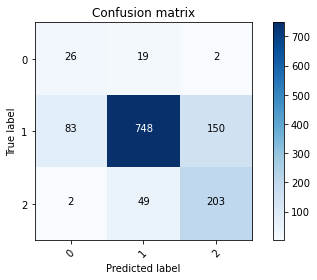

In [42]:
# Confusion Matrix for the test data

cnf_matrix_test_rf = confusion_matrix(target_test, predictions_test_rf)
np.set_printoptions(precision=2)
print("Confusion Matrix Test Data:")
display(plot_confusion_matrix(cnf_matrix_test_rf, classes=np.array([0,1,2])))

#### Feature Permutation: Model without pH and density 

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,sulphates,alcohol
0,1.0,0.264463,0.126667,0.216867,0.308282,0.059801,0.152778,0.377880,0.129213,0.115942
1,1.0,0.206612,0.146667,0.204819,0.015337,0.066445,0.045139,0.290323,0.151685,0.217391
2,1.0,0.355372,0.133333,0.240964,0.096626,0.068106,0.100694,0.209677,0.123596,0.304348
3,1.0,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.101124,0.275362
4,1.0,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.101124,0.275362


Makro F1-Score Train Data:


0.9309293886332775

Makro F1-Score Test Data:


0.6094741307753999

Makro Precision Train Data:


0.9328232589173133

Makro Precision Test Data:


0.5739622662462389

Makro Recall Train Data:


0.9316152079612147

Makro Recall Test Data:


0.704623992565052

Confusion Matrix Train Data:


None

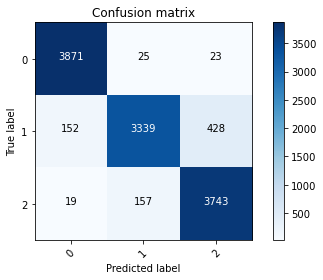

In [50]:
# Seperation of features and the target variable in two different data frames and dropping the columns quality, pH, and density
features = wine_data.drop(columns=['quality', 'pH', 'density'])
display(features.head())
target = wine_data.drop(columns=['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'])
target = target['quality'].ravel()

# Train test split
data_train, data_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target)

# Oversampling
data_train_smt = data_train.copy() 
target_train_smt = target_train.copy() 

smt = SMOTE(random_state=42)
data_train, target_train = smt.fit_resample(data_train_smt, target_train_smt)

# Create estimator and pipeline
random_forest = RandomForestClassifier(random_state=0, max_depth = 11, n_estimators = 500, max_features=0.3, min_samples_leaf=3,
    min_samples_split=8)
pipeline_rf = Pipeline([('estimator', random_forest)])

# Fit the model and predict the values for the train data
pipeline_rf.fit(data_train, target_train)
predictions_train_rf = pipeline_rf.predict(data_train)

# Predict values for the test data
predictions_test_rf = pipeline_rf.predict(data_test)

# Makro F1-Score
print("Makro F1-Score Train Data:")
f1_score_train_rf = f1_score(target_train, predictions_train_rf, average='macro')
display(f1_score_train_rf)

print("Makro F1-Score Test Data:")
f1_score_test_rf = f1_score(target_test, predictions_test_rf, average='macro')
display(f1_score_test_rf)

# Makro Precision Score
print("Makro Precision Train Data:")
precision_train_rf = precision_score(target_train, predictions_train_rf, average='macro', zero_division = 0)
display(precision_train_rf)

print("Makro Precision Test Data:")
precision_test_rf = precision_score(target_test, predictions_test_rf, average='macro', zero_division = 0)
display(precision_test_rf)

# Makro Recall Score
print("Makro Recall Train Data:")
recall_train_rf = recall_score(target_train, predictions_train_rf, average='macro')
display(recall_train_rf)

print("Makro Recall Test Data:")
recall_test_rf = recall_score(target_test, predictions_test_rf, average='macro')
display(recall_test_rf)

# Confusion Matrix for the training data
cnf_matrix_train_rf = confusion_matrix(target_train, predictions_train_rf)
np.set_printoptions(precision=2)
print("Confusion Matrix Train Data:")
display(plot_confusion_matrix(cnf_matrix_train_rf, classes=np.array([0,1,2])))

Confusion Matrix Test Data:


None

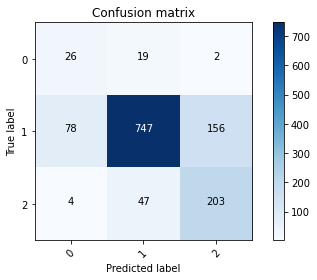

In [44]:
# Confusion Matrix for the test data

cnf_matrix_test_rf = confusion_matrix(target_test, predictions_test_rf)
np.set_printoptions(precision=2)
print("Confusion Matrix Test Data:")
display(plot_confusion_matrix(cnf_matrix_test_rf, classes=np.array([0,1,2])))

#### Feature Correlation: Model without fixed acidity, alcohol, type, residual sugar, and density

,volatile acidity,citric acid,chlorides,free sulfur dioxide,total sulfur dioxide,pH,sulphates
0,0.126667,0.216867,0.059801,0.152778,0.377880,0.217054,0.129213
1,0.146667,0.204819,0.066445,0.045139,0.290323,0.449612,0.151685
2,0.133333,0.240964,0.068106,0.100694,0.209677,0.418605,0.123596
3,0.100000,0.192771,0.081395,0.159722,0.414747,0.364341,0.101124
4,0.100000,0.192771,0.081395,0.159722,0.414747,0.364341,0.101124


Makro F1-Score Train Data:


0.9073728816353824

Makro F1-Score Test Data:


0.5792151680448895

Makro Precision Train Data:


0.9098332454047456

Makro Precision Test Data:


0.5484952960674363

Makro Recall Train Data:


0.9084800544356554

Makro Recall Test Data:


0.7014237167260203

Confusion Matrix Train Data:


None

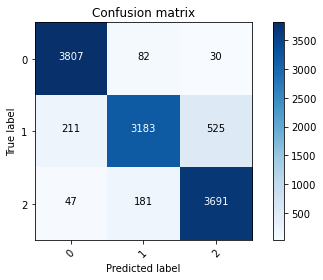

In [45]:
# Seperation of features and the target variable in two different data frames and dropping the columns fixed acidity, alcohol, type, residual sugar, and density
features = wine_data.drop(columns=['quality', 'type', 'fixed acidity', 'alcohol', 'density', 'residual sugar'])
display(features.head())
target = wine_data.drop(columns=['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'])
target = target['quality'].ravel()

# Train test split
data_train, data_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target)

# Oversampling
data_train_smt = data_train.copy() 
target_train_smt = target_train.copy() 

smt = SMOTE(random_state=42)
data_train, target_train = smt.fit_resample(data_train_smt, target_train_smt)

# Create estimator and pipeline
random_forest = RandomForestClassifier(random_state=0, max_depth = 11, n_estimators = 500, max_features=0.3, min_samples_leaf=3,
    min_samples_split=8)
pipeline_rf = Pipeline([('estimator', random_forest)])

# Fit the model and predict the values for the train data
pipeline_rf.fit(data_train, target_train)
predictions_train_rf = pipeline_rf.predict(data_train)

# Predict values for the test data
predictions_test_rf = pipeline_rf.predict(data_test)

# Makro F1-Score
print("Makro F1-Score Train Data:")
f1_score_train_rf = f1_score(target_train, predictions_train_rf, average='macro')
display(f1_score_train_rf)

print("Makro F1-Score Test Data:")
f1_score_test_rf = f1_score(target_test, predictions_test_rf, average='macro')
display(f1_score_test_rf)

# Makro Precision Score
print("Makro Precision Train Data:")
precision_train_rf = precision_score(target_train, predictions_train_rf, average='macro', zero_division = 0)
display(precision_train_rf)

print("Makro Precision Test Data:")
precision_test_rf = precision_score(target_test, predictions_test_rf, average='macro', zero_division = 0)
display(precision_test_rf)

# Makro Recall Score
print("Makro Recall Train Data:")
recall_train_rf = recall_score(target_train, predictions_train_rf, average='macro')
display(recall_train_rf)

print("Makro Recall Test Data:")
recall_test_rf = recall_score(target_test, predictions_test_rf, average='macro')
display(recall_test_rf)

# Confusion Matrix for the training data
cnf_matrix_train_rf = confusion_matrix(target_train, predictions_train_rf)
np.set_printoptions(precision=2)
print("Confusion Matrix Train Data:")
display(plot_confusion_matrix(cnf_matrix_train_rf, classes=np.array([0,1,2])))

Confusion Matrix Test Data:


None

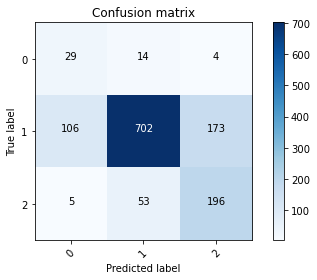

In [46]:
# Confusion Matrix for the test data

cnf_matrix_test_rf = confusion_matrix(target_test, predictions_test_rf)
np.set_printoptions(precision=2)
print("Confusion Matrix Test Data:")
display(plot_confusion_matrix(cnf_matrix_test_rf, classes=np.array([0,1,2])))

### Second Hyperparameter Tuning

In [49]:
# Seperation of features and the target variable in two different data frames
features = wine_data.drop(columns=['quality'])
target = wine_data.drop(columns=['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'])
target = target['quality'].ravel()

# Train test split
data_train, data_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target)

# Oversampling
data_train_smt = data_train.copy() 
target_train_smt = target_train.copy() 

smt = SMOTE(random_state=42)
data_train, target_train = smt.fit_resample(data_train_smt, target_train_smt)

# Create an estimator
random_forest = RandomForestClassifier()

# Specify the parameter grid
parameters = {
    #'max_depth': range(5, 14),
    #'n_estimators': [100, 300, 500, 700],
    'max_features': [None, sqrt, 0.3, 2],
    'min_samples_leaf': [3, 4, 5],
    #'min_samples_split': [8, 10, 12],
    
}

# Specify the cross validation
stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Create the grid search instance
grid_search_estimator = GridSearchCV(random_forest, parameters, scoring='f1_macro', cv=stratified_10_fold_cv, n_jobs = -1, verbose = 2, return_train_score=False)

# Run the grid search
grid_search_estimator.fit(data_train, target_train)

# Print the results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)
display(results)
    
# Print the best parameter setting
print("best score is {} with params {}".format(grid_search_estimator.best_score_, grid_search_estimator.best_params_))

Fitting 10 folds for each of 12 candidates, totalling 120 fits


/Users/I500970/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.91 0.9  0.9   nan  nan  nan 0.92 0.91 0.9  0.92 0.91 0.9 ]
  warnings.warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,10.889375,0.166888,0.052727,0.006922,None,3,"{'max_features': None, 'min_samples_leaf': 3}",0.923855,0.915269,0.912010,0.916162,0.900017,0.918042,0.904768,0.905987,0.905444,0.906041,0.910759,0.007073,3
1,11.281850,0.416982,0.058735,0.010129,None,4,"{'max_features': None, 'min_samples_leaf': 4}",0.921974,0.913443,0.899128,0.910974,0.887979,0.907642,0.893668,0.901794,0.899716,0.904295,0.904061,0.009405,6
2,11.580477,0.260047,0.055284,0.010652,None,5,"{'max_features': None, 'min_samples_leaf': 5}",0.914447,0.905688,0.893678,0.902292,0.882538,0.902333,0.888986,0.889802,0.887629,0.887892,0.895528,0.009600,9
3,0.066689,0.006941,0.000000,0.000000,<built-in function sqrt>,3,"{'max_features': <built-in function sqrt>, 'mi...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
4,0.084747,0.019007,0.000000,0.000000,<built-in function sqrt>,4,"{'max_features': <built-in function sqrt>, 'mi...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
5,0.077427,0.010021,0.000000,0.000000,<built-in function sqrt>,5,"{'max_features': <built-in function sqrt>, 'mi...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
6,3.631860,0.076739,0.056491,0.012121,0.3,3,"{'max_features': 0.3, 'min_samples_leaf': 3}",0.934273,0.925370,0.911435,0.922132,0.908892,0.926077,0.917920,0.917485,0.917066,0.907651,0.918830,0.007930,1
7,3.548573,0.088696,0.053995,0.005843,0.3,4,"{'max_features': 0.3, 'min_samples_leaf': 4}",0.927602,0.925450,0.895302,0.903963,0.896690,0.915658,0.909793,0.912242,0.914482,0.902647,0.910383,0.010431,4
8,3.580796,0.018524,0.056469,0.009258,0.3,5,"{'max_features': 0.3, 'min_samples_leaf': 5}",0.919839,0.907918,0.889927,0.898220,0.886058,0.906143,0.896014,0.897111,0.900313,0.897941,0.899948,0.009064,7
9,2.757141,0.036859,0.072278,0.015794,2,3,"{'max_features': 2, 'min_samples_leaf': 3}",0.938557,0.931458,0.913451,0.911787,0.911185,0.919111,0.920646,0.910730,0.913436,0.913860,0.918422,0.008982,2


best score is 0.9188301358674004 with params {'max_features': 0.3, 'min_samples_leaf': 3}


#### Model with Hyperparameter Tuning

Makro F1-Score Train Data:


0.9604063614101962

Makro F1-Score Test Data:


0.6320363916208224

Makro Precision Train Data:


0.9614345287769598

Makro Precision Test Data:


0.59614663772345

Makro Recall Train Data:


0.9606192055796546

Makro Recall Test Data:


0.7045148660536112

Confusion Matrix Train Data:


None

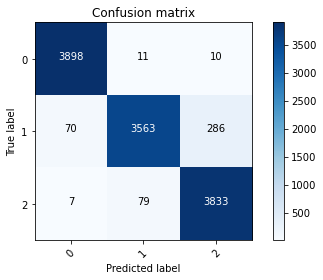

In [53]:
# Changing hyperparameters 

# Create estimator and pipeline
random_forest = RandomForestClassifier(random_state=0, max_depth = 13, n_estimators = 700, max_features=0.3, min_samples_leaf=3,
    min_samples_split=8)
pipeline_rf = Pipeline([('estimator', random_forest)])

# Fit the model and predict the values for the train data
pipeline_rf.fit(data_train, target_train)
predictions_train_rf = pipeline_rf.predict(data_train)

# Predict values for the test data
predictions_test_rf = pipeline_rf.predict(data_test)

# Makro F1-Score
print("Makro F1-Score Train Data:")
f1_score_train_rf = f1_score(target_train, predictions_train_rf, average='macro')
display(f1_score_train_rf)

print("Makro F1-Score Test Data:")
f1_score_test_rf = f1_score(target_test, predictions_test_rf, average='macro')
display(f1_score_test_rf)

# Makro Precision Score
print("Makro Precision Train Data:")
precision_train_rf = precision_score(target_train, predictions_train_rf, average='macro', zero_division = 0)
display(precision_train_rf)

print("Makro Precision Test Data:")
precision_test_rf = precision_score(target_test, predictions_test_rf, average='macro', zero_division = 0)
display(precision_test_rf)

# Makro Recall Score
print("Makro Recall Train Data:")
recall_train_rf = recall_score(target_train, predictions_train_rf, average='macro')
display(recall_train_rf)

print("Makro Recall Test Data:")
recall_test_rf = recall_score(target_test, predictions_test_rf, average='macro')
display(recall_test_rf)

# Confusion Matrix for the training data
cnf_matrix_train_rf = confusion_matrix(target_train, predictions_train_rf)
np.set_printoptions(precision=2)
print("Confusion Matrix Train Data:")
display(plot_confusion_matrix(cnf_matrix_train_rf, classes=np.array([0,1,2])))

Makro F1-Score Train Data:


0.9581963988395562

Makro F1-Score Test Data:


0.6324892821452037

Makro Precision Train Data:


0.9592377488442492

Makro Precision Test Data:


0.595174495738426

Makro Recall Train Data:


0.958407757080888

Makro Recall Test Data:


0.7144778831528874

Confusion Matrix Train Data:


None

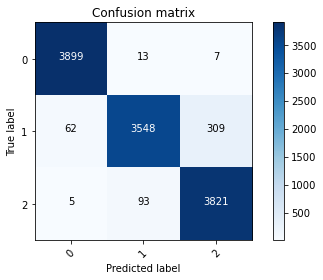

In [52]:
# Changing hyperparameters 

# Create estimator and pipeline
random_forest = RandomForestClassifier(random_state=0, max_depth = 13, n_estimators = 700, max_features=2, min_samples_leaf=3,
    min_samples_split=8)
pipeline_rf = Pipeline([('estimator', random_forest)])

# Fit the model and predict the values for the train data
pipeline_rf.fit(data_train, target_train)
predictions_train_rf = pipeline_rf.predict(data_train)

# Predict values for the test data
predictions_test_rf = pipeline_rf.predict(data_test)

# Makro F1-Score
print("Makro F1-Score Train Data:")
f1_score_train_rf = f1_score(target_train, predictions_train_rf, average='macro')
display(f1_score_train_rf)

print("Makro F1-Score Test Data:")
f1_score_test_rf = f1_score(target_test, predictions_test_rf, average='macro')
display(f1_score_test_rf)

# Makro Precision Score
print("Makro Precision Train Data:")
precision_train_rf = precision_score(target_train, predictions_train_rf, average='macro', zero_division = 0)
display(precision_train_rf)

print("Makro Precision Test Data:")
precision_test_rf = precision_score(target_test, predictions_test_rf, average='macro', zero_division = 0)
display(precision_test_rf)

# Makro Recall Score
print("Makro Recall Train Data:")
recall_train_rf = recall_score(target_train, predictions_train_rf, average='macro')
display(recall_train_rf)

print("Makro Recall Test Data:")
recall_test_rf = recall_score(target_test, predictions_test_rf, average='macro')
display(recall_test_rf)

# Confusion Matrix for the training data
cnf_matrix_train_rf = confusion_matrix(target_train, predictions_train_rf)
np.set_printoptions(precision=2)
print("Confusion Matrix Train Data:")
display(plot_confusion_matrix(cnf_matrix_train_rf, classes=np.array([0,1,2])))

Confusion Matrix Test Data:


None

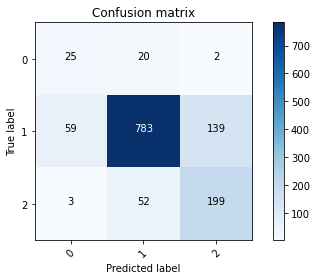

In [54]:
# Confusion Matrix for the test data

cnf_matrix_test_rf = confusion_matrix(target_test, predictions_test_rf)
np.set_printoptions(precision=2)
print("Confusion Matrix Test Data:")
display(plot_confusion_matrix(cnf_matrix_test_rf, classes=np.array([0,1,2])))